In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, ParameterGrid, KFold
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.8.0'

### MLP module

In [3]:
class MLP(object):
    def __init__(self, input_size, output_size, hidden_size=256, device=None, optimizer='SGD'):
        """
        input_size: int, size of input layer
        output_size: int, size of output layer
        hidden_size: int, size of hidden layer
        device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Execution
        """
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.device = device
        self.optimizer = optimizer
 
        # Initialize weights for input layer
        self.W1 = tf.Variable(tf.random.normal([self.input_size, self.hidden_size], stddev=0.1))
        self.b1 = tf.Variable(tf.random.normal([1, self.hidden_size]))

        # Initialize weights for the first hidden layer
        self.W12 = tf.Variable(tf.random.normal([self.hidden_size, self.hidden_size], stddev=0.1))
        self.b12 = tf.Variable(tf.random.normal([1, self.hidden_size]))

        # Initialize weights between the first hidden layer and the second hidden layer
        self.W22 = tf.Variable(tf.random.normal([self.hidden_size, self.hidden_size], stddev=0.1))
        self.b22 = tf.Variable(tf.random.normal([1, self.hidden_size]))

        # Initialize weights between the second hidden layer and the output layer
        self.W2 = tf.Variable(tf.random.normal([self.hidden_size, self.output_size], stddev=0.1))
        self.b2 = tf.Variable(tf.random.normal([1, self.output_size]))

        # define variables to be updated during backpropagation
        self.variables = [self.W1, self.W12, self.W22, self.W2, self.b1, self.b12, self.b22, self.b2]

        ### define extra variables for optimizer
        self.m = []
        self.v = []
        self.u = []
        for var in self.variables:
            self.m.append(tf.Variable(tf.zeros_like(var), trainable=False))
            self.v.append(tf.Variable(tf.zeros_like(var), trainable=False))
            self.u.append(tf.Variable(tf.zeros_like(var), trainable=False))
        self.t = 0
        self.alpha = 10e-3
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.beta_3 = 0.999987
        self.epsilon = 10e-8

    
    def forward(self, X, dropout=0.0):
        """ Forward pass
        X: tensor, inputs
        """
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                self.y = self.compute_output(X, dropout)
        else:
            self.y = self.compute_output(X, dropout)
        
        return self.y
    
    def loss(self, y_pred, y_true, beta=0.0):
        """
        y_pred: tensor of shape (batch_size, output_size),
        y_true: tensor of shape (batch_size), true labels are provided as integers
        beta: weight of penalty term
        """
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        y_true_tf = tf.cast(y_true, dtype=tf.int32)
        cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_tf, logits=y_pred_tf))
        l2_penalty = tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W12) + tf.nn.l2_loss(self.W22) +  tf.nn.l2_loss(self.W2)
        total_cost = cost + beta * l2_penalty

        return total_cost
    
    def backward(self, X_train, y_train, dropout=0.0, beta=0.0, lr=1e-6):
        """
        backward pass
        X_train: tensor of shape (batch_size, input_size)
        y_train: tensor of shape (batch_size)
        dropout:
        beta:
        lr:
        """

        with tf.GradientTape() as tape:
            predicted = self.forward(X_train, dropout=dropout)
            current_loss = self.loss(predicted, y_train, beta=beta)
        grads = tape.gradient(current_loss, self.variables)

        if self.optimizer == 'SGD':
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
            optimizer.apply_gradients(zip(grads, self.variables))
        elif self.optimizer == 'Adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            optimizer.apply_gradients(zip(grads, self.variables))
        else:
            self.t += 1
            self.alpha = lr

            for i in range(len(self.variables)):
                mt = tf.math.add(tf.math.scalar_mul(self.beta_1, self.m[i]), tf.math.scalar_mul(1 - self.beta_1, grads[i]))
                self.m[i].assign(mt)

                vt = tf.math.add(tf.math.scalar_mul(self.beta_2, self.v[i]), tf.math.scalar_mul(1 - self.beta_2, tf.pow(grads[i], 2.0)))
                self.v[i].assign(vt)

                ut = tf.math.add(tf.math.scalar_mul(self.beta_3, self.u[i]), tf.math.scalar_mul(1 - self.beta_3, tf.pow(grads[i], 3.0)))
                self.u[i].assign(ut)

                beta_1_power = tf.pow(self.beta_1, self.t)
                beta_2_power = tf.pow(self.beta_2, self.t)
                beta_3_power = tf.pow(self.beta_3, self.t)

                mt_hat = tf.math.divide(mt, 1 - beta_1_power)
                vt_hat = tf.math.divide(vt, 1 - beta_2_power)
                ut_hat = tf.math.divide(ut, 1 - beta_3_power)
                
                vt_power = tf.pow(vt_hat, 1.0/2.0)
                ut_power = tf.math.multiply(tf.math.sign(ut_hat), tf.math.pow(tf.abs(ut_hat), 1.0/3.0))
                _denominator = tf.math.add(vt_power, tf.math.scalar_mul(self.epsilon, ut_power))
                # to avoid divide by zero
                delta = tf.math.divide(mt_hat, tf.math.add(_denominator, 10e-8))
                new_var = self.variables[i] - tf.math.scalar_mul(self.alpha, delta)
                self.variables[i].assign(new_var)

        return predicted, current_loss, grads
    
    def compute_output(self, X, dropout):
        """Custom method to obtain output tensor during forward pass
        X: tensor, input
        dropout: dropout rate
        """

        # Cast X to float32
        X_tf = tf.cast(X, dtype=tf.float32)

        # compute values in the input layer
        logits1 = tf.matmul(X_tf, self.W1) + self.b1
        input_layer = tf.nn.relu(logits1)

        # compute values in the first hidden layer
        logits12 = tf.matmul(input_layer, self.W12) + self.b12
        hidden_layer1 = tf.nn.relu(logits12)
        # hidden_layer1_dropout = tf.nn.dropout(hidden_layer1, rate=dropout_rate, seed=1)
        hidden_layer1_dropout = tf.nn.experimental.stateless_dropout(hidden_layer1, rate=dropout, seed=[0,1])

        # compute values in the second hidden layer
        logits22 = tf.matmul(hidden_layer1_dropout, self.W22) + self.b22
        hidden_layer2 = tf.nn.relu(logits22)
        # hidden_layer2_dropout = tf.nn.dropout(hidden_layer2, rate = dropout_rate, seed = 2)
        hidden_layer2_dropout = tf.nn.experimental.stateless_dropout(hidden_layer2, rate=dropout, seed=[1,2])

        # compute values in the output layer
        output = tf.matmul(hidden_layer2_dropout, self.W2) + self.b2
        return output


In [4]:
def load_data(dataset='fashion_mnist', valid_size=0.2):
    if dataset == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    elif dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    else:
        print("invalid dataset")
        return
   
    # scale data to the range of [0,1]
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    x_train_tf = tf.reshape(x_train, (x_train.shape[0], -1))
    x_test_tf = tf.reshape(x_test, (x_test.shape[0], -1))
    
    return x_train_tf, y_train, x_test_tf, y_test


def accuracy(predictions, labels):
    preds = tf.argmax(predictions, axis=1).numpy()
    acc = np.sum(preds == labels) / predictions.shape[0]
    return 100.0* acc


def train(model, x_train_tf, y_train, x_validation_tf, y_validation, 
          batch_size=32, 
          dropout_rate=0.0, 
          beta=0.0, 
          learning_rate=1e-5, 
          epochs=10):
    
    epoch = 0
    global_step = 0
    eval_steps = 100
    train_data_size, validation_data_size = x_train_tf.shape[0], x_validation_tf.shape[0]

    train_losses = []
    eval_losses = []
    train_accuracy = []
    eval_accuracy = []
    epoch_times = []

    while epoch < epochs:
        time_start = time.time()

        lt = 0
        # Split dataset into batches
        train_ds = tf.data.Dataset.from_tensor_slices((x_train_tf, y_train)).shuffle(train_data_size, 
                                                                                 seed=epoch*(1234)).batch(batch_size)
        
        for inputs, outputs in train_ds:
            train_preds, train_loss, _ = model.backward(inputs, outputs, dropout=dropout_rate, lr=learning_rate, beta=beta)
            lt = lt + train_loss

        _train_preds = model.forward(x_train_tf, dropout=0.0)
        _train_acc = accuracy(tf.nn.softmax(_train_preds), y_train)
        train_losses.append(lt)
        train_accuracy.append(_train_acc)

        _eval_preds = model.forward(x_validation_tf, dropout=0.0)
        _eval_loss = model.loss(_eval_preds, y_validation, beta=0.0)
        _eval_acc = accuracy(tf.nn.softmax(_eval_preds), y_validation)
        eval_losses.append(_eval_loss)
        eval_accuracy.append(_eval_acc)

        print('Epoch={} - Train Loss:={}, Evaluation Loss:={}, Train Acc:={}, Evaluation Acc:={}'.format(epoch, lt, _eval_loss, _train_acc, _eval_acc))
        epoch += 1
        time_end = time.time()
        epoch_times.append(time_end - time_start)

    return train_losses, eval_losses, train_accuracy, eval_accuracy, epoch_times

def test(model, x_test_tf, y_test):
    test_preds = model.forward(x_test_tf, dropout=0.0)
    test_acc = accuracy(tf.nn.softmax(test_preds), y_test)
    return test_acc


In [5]:
def plot_learning_curves(train_losses, test_losses, train_acc, test_acc):
    fig, axs = plt.subplots(1,2, figsize=(20, 10))
    axs[0].plot(train_losses, label="train error", color='blue')
    axs[0].plot(test_losses, label="test error", color='orange')
    axs[0].set_xlabel("steps")
    axs[0].set_ylabel("loss")
    axs[0].legend(loc="upper right")

    axs[1].plot(train_acc, label="train acc", color="blue")
    axs[1].plot(test_acc, label="test acc", color='orange')
    axs[1].set_xlabel("steps")
    axs[1].set_ylabel("accuracy")
    axs[1].legend(loc="upper right")

    plt.show()

## MINST Dataset

visualize a selected sample.



11501568/11490434 [==============================] - 0s 0us/step
sample image shape: (28, 28)
sample image label: 5


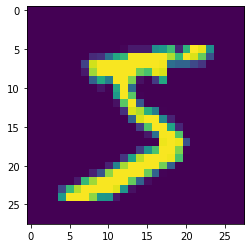

In [7]:
train_x, train_y, test_x, test_y = load_data(dataset="mnist")
sample = tf.reshape(train_x[0], (28,28))
print(f"sample image shape: {sample.shape}")
print(f"sample image label: {train_y[0]}")
plt.imshow(sample)

### Model1: without any regularization + SGD optimizer

In [ ]:
image_size = 28
input_size = image_size * image_size
output_size = 10

hidden_size = 512
learning_rate = 1e-4
batch_size = 32
epochs = 10
optimizer = "SGD"

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i + 2)
    
    x_train, y_train, x_test, y_test = load_data(dataset="mnist")

    model1 = MLP(input_size, output_size, hidden_size = hidden_size, optimizer=optimizer)
    train_losses, eval_losses, train_accuracy, eval_accuracy, _epoch_times = train(model1, x_train, y_train, x_test, y_test,
                                                                 batch_size=batch_size,
                                                                 learning_rate=learning_rate,
                                                                 epochs=epochs)
    acc = test(model1, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))   

Epoch=0 - Train Loss:=3842.14013671875, Evaluation Loss:=0.9717162251472473, Train Acc:=67.79333333333334, Evaluation Acc:=68.87
Epoch=1 - Train Loss:=1566.403076171875, Evaluation Loss:=0.6843574047088623, Train Acc:=77.02166666666666, Evaluation Acc:=78.14999999999999
Epoch=2 - Train Loss:=1230.8466796875, Evaluation Loss:=0.5752062797546387, Train Acc:=80.69666666666667, Evaluation Acc:=82.04
Epoch=3 - Train Loss:=1069.9345703125, Evaluation Loss:=0.5124307870864868, Train Acc:=82.92, Evaluation Acc:=83.98
Epoch=4 - Train Loss:=969.90869140625, Evaluation Loss:=0.47186920046806335, Train Acc:=84.50333333333333, Evaluation Acc:=85.69
Epoch=5 - Train Loss:=899.9153442382812, Evaluation Loss:=0.44089004397392273, Train Acc:=85.54666666666667, Evaluation Acc:=86.66
Epoch=6 - Train Loss:=846.3643188476562, Evaluation Loss:=0.4206176698207855, Train Acc:=86.26666666666667, Evaluation Acc:=86.92
Epoch=7 - Train Loss:=803.5297241210938, Evaluation Loss:=0.3992197513580322, Train Acc:=87.095

the mean of 10 runs is 88.526, and the variance is 0.16448399999999969
the average running time for one epoch is: 31.630993814468383


{'boxes': [<matplotlib.lines.Line2D at 0x7fb3e07d33d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fb3e07df410>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb3e0766450>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fb3e07dfed0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb3e07d3950>,
  <matplotlib.lines.Line2D at 0x7fb3e07d3e90>]}

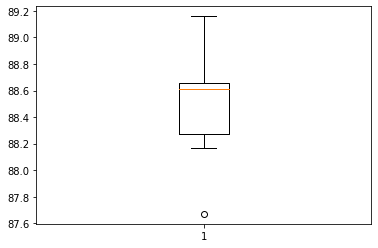

In [ ]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

### Model2: with dropout regularization + SGD optimizer

In [8]:
input_size = 28 * 28
output_size = 10
optimizer = "SGD"

hidden_size = 512
batch_size = 32
learning_rate = 1e-3
epochs = 10
dropout = 0.2

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i + 2)
    x_train_tf, y_train_tf, x_test_tf, y_test_tf = load_data(dataset="mnist")

    model2 = MLP(input_size, output_size, hidden_size, optimizer=optimizer)
    train_losses, eval_losses, train_accuracy, test_accuracy, _epoch_times = train(model2, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = dropout)

    acc = test(model2, x_test_tf, y_test_tf)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=2290.04638671875, Evaluation Loss:=0.42360302805900574, Train Acc:=86.495, Evaluation Acc:=86.99
Epoch=1 - Train Loss:=994.1759033203125, Evaluation Loss:=0.3398791551589966, Train Acc:=89.40833333333333, Evaluation Acc:=89.92
Epoch=2 - Train Loss:=809.4541625976562, Evaluation Loss:=0.3048611581325531, Train Acc:=90.85833333333333, Evaluation Acc:=90.95
Epoch=3 - Train Loss:=711.1637573242188, Evaluation Loss:=0.2712585926055908, Train Acc:=91.84833333333333, Evaluation Acc:=91.74
Epoch=4 - Train Loss:=652.8272094726562, Evaluation Loss:=0.24812550842761993, Train Acc:=92.63166666666666, Evaluation Acc:=92.44
Epoch=5 - Train Loss:=593.2278442382812, Evaluation Loss:=0.23679064214229584, Train Acc:=93.045, Evaluation Acc:=92.94
Epoch=6 - Train Loss:=560.711669921875, Evaluation Loss:=0.22530443966388702, Train Acc:=93.585, Evaluation Acc:=93.33
Epoch=7 - Train Loss:=528.3485107421875, Evaluation Loss:=0.2184758484363556, Train Acc:=93.74166666666667, Evaluation Ac

the mean of 10 runs is 93.926, and the variance is 0.03490399999999957
the average running time for one epoch is: 19.75828253030777


{'boxes': [<matplotlib.lines.Line2D at 0x7fec522021d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fec5220e250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fec52214290>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fec5220ed10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fec52202790>,
  <matplotlib.lines.Line2D at 0x7fec52202cd0>]}

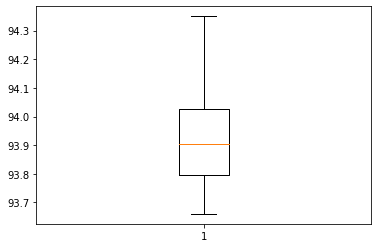

In [9]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

### Model3: without regularization + Adam optimizer

In [10]:
image_size = 28
input_size = image_size * image_size
output_size = 10


hidden_size = 512
learning_rate = 1e-3
batch_size = 32
epochs = 10
optimizer = "Adam"

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i+3)

    x_train, y_train, x_test, y_test = load_data(dataset="mnist")
    model3 = MLP(input_size, output_size, hidden_size = hidden_size, optimizer=optimizer)
    train_losses, eval_losses, train_accuracy, eval_accuracy, _epoch_times = train(model3, x_train, y_train, x_test, y_test,
                                                                 batch_size=batch_size,
                                                                 learning_rate=learning_rate,
                                                                 epochs=epochs)
    acc = test(model3, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=1132.806640625, Evaluation Loss:=0.35690948367118835, Train Acc:=96.24333333333334, Evaluation Acc:=95.93
Epoch=1 - Train Loss:=628.921142578125, Evaluation Loss:=0.23519393801689148, Train Acc:=97.81166666666667, Evaluation Acc:=97.24000000000001
Epoch=2 - Train Loss:=448.2666931152344, Evaluation Loss:=0.27761533856391907, Train Acc:=97.73666666666668, Evaluation Acc:=97.06
Epoch=3 - Train Loss:=361.69970703125, Evaluation Loss:=0.2166418433189392, Train Acc:=98.555, Evaluation Acc:=97.58
Epoch=4 - Train Loss:=289.9563903808594, Evaluation Loss:=0.23908691108226776, Train Acc:=98.735, Evaluation Acc:=97.67
Epoch=5 - Train Loss:=227.55096435546875, Evaluation Loss:=0.27257248759269714, Train Acc:=98.73833333333333, Evaluation Acc:=97.49
Epoch=6 - Train Loss:=196.1151885986328, Evaluation Loss:=0.2719242572784424, Train Acc:=99.03833333333333, Evaluation Acc:=97.44
Epoch=7 - Train Loss:=151.28187561035156, Evaluation Loss:=0.27489936351776123, Train Acc:=99.288333

the mean of 10 runs is 97.925, and the variance is 0.03438499999999957
the average running time for one epoch is: 32.67204792261124


{'boxes': [<matplotlib.lines.Line2D at 0x7fec520bfd50>],
 'caps': [<matplotlib.lines.Line2D at 0x7fec520c6e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fec520cce50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fec520cc910>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fec520c6390>,
  <matplotlib.lines.Line2D at 0x7fec520c68d0>]}

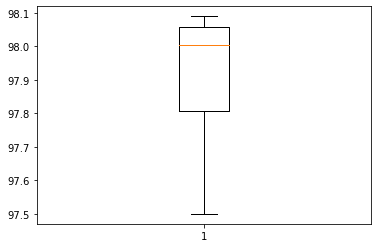

In [11]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

### Model4: with dropout regularization + Adam optimizer

In [12]:
input_size = 28 * 28
output_size = 10
optimizer = "Adam"

hidden_size = 512
batch_size = 32
learning_rate = 1e-3
epochs = 10
dropout = 0.2

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i+4)

    x_train, y_train, x_test, y_test = load_data(dataset="mnist")

    model4 = MLP(input_size, output_size, hidden_size, optimizer=optimizer)
    train_losses, eval_losses, train_accuracy, test_accuracy, _epoch_times = train(model4, x_train, y_train, x_test, y_test,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = dropout)
    acc = test(model4, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=1356.58154296875, Evaluation Loss:=0.4098091721534729, Train Acc:=95.46666666666667, Evaluation Acc:=95.21
Epoch=1 - Train Loss:=747.9056396484375, Evaluation Loss:=0.279823899269104, Train Acc:=97.36166666666666, Evaluation Acc:=96.83
Epoch=2 - Train Loss:=551.6994018554688, Evaluation Loss:=0.2894348204135895, Train Acc:=97.845, Evaluation Acc:=97.1
Epoch=3 - Train Loss:=449.4662170410156, Evaluation Loss:=0.23796038329601288, Train Acc:=98.38333333333334, Evaluation Acc:=97.56
Epoch=4 - Train Loss:=390.0718688964844, Evaluation Loss:=0.2235444039106369, Train Acc:=98.57000000000001, Evaluation Acc:=97.64
Epoch=5 - Train Loss:=327.2735595703125, Evaluation Loss:=0.21702821552753448, Train Acc:=98.75500000000001, Evaluation Acc:=97.72999999999999
Epoch=6 - Train Loss:=297.8033752441406, Evaluation Loss:=0.24531279504299164, Train Acc:=98.92166666666667, Evaluation Acc:=97.78
Epoch=7 - Train Loss:=261.1590270996094, Evaluation Loss:=0.2368413507938385, Train Acc:=

the mean of 10 runs is 97.95599999999999, and the variance is 0.012363999999999787
the average running time for one epoch is: 36.38002517223358


{'boxes': [<matplotlib.lines.Line2D at 0x7fec3c74c610>],
 'caps': [<matplotlib.lines.Line2D at 0x7fec3c7516d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fec3c759550>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fec3c759050>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fec3c74cc10>,
  <matplotlib.lines.Line2D at 0x7fec3c751190>]}

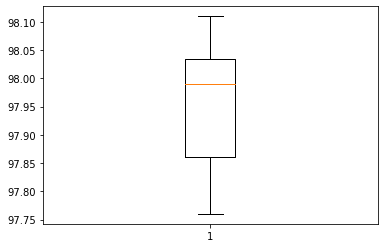

In [13]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

### Model5: without regularization + custom optimizer

In [14]:
image_size = 28
input_size = image_size * image_size
output_size = 10

hidden_size = 512
learning_rate = 1e-3
batch_size = 32
epochs = 10
optimizer="custom"

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i + 5)
    x_train, y_train, x_test, y_test = load_data(dataset="mnist")

    model5 = MLP(input_size, output_size, hidden_size = hidden_size, optimizer=optimizer)
    train_losses, eval_losses, train_accuracy, eval_accuracy, _epoch_times = train(model5, x_train, y_train, x_test, y_test,
                                                                 batch_size=batch_size,
                                                                 learning_rate=learning_rate,
                                                                 epochs=epochs)
    acc = test(model5, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=493.386962890625, Evaluation Loss:=0.12190697342157364, Train Acc:=96.85333333333334, Evaluation Acc:=96.22
Epoch=1 - Train Loss:=189.908203125, Evaluation Loss:=0.10220446437597275, Train Acc:=98.015, Evaluation Acc:=96.99
Epoch=2 - Train Loss:=139.19781494140625, Evaluation Loss:=0.11161176860332489, Train Acc:=98.07666666666667, Evaluation Acc:=96.73
Epoch=3 - Train Loss:=109.76973724365234, Evaluation Loss:=0.0872621238231659, Train Acc:=99.07666666666667, Evaluation Acc:=97.57000000000001
Epoch=4 - Train Loss:=93.10645294189453, Evaluation Loss:=0.1067657470703125, Train Acc:=98.75333333333333, Evaluation Acc:=97.18
Epoch=5 - Train Loss:=76.36380767822266, Evaluation Loss:=0.11077536642551422, Train Acc:=98.75333333333333, Evaluation Acc:=97.36
Epoch=6 - Train Loss:=67.23216247558594, Evaluation Loss:=0.10927281528711319, Train Acc:=99.015, Evaluation Acc:=97.28999999999999
Epoch=7 - Train Loss:=65.19229888916016, Evaluation Loss:=0.12171436846256256, Train A

the mean of 10 runs is 97.673, and the variance is 0.06458099999999901
the average running time for one epoch is: 36.8445925283432


{'boxes': [<matplotlib.lines.Line2D at 0x7fec3c5aac50>],
 'caps': [<matplotlib.lines.Line2D at 0x7fec3c5b3d10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fec3c5b9d50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fec3c5b9810>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fec3c5b3290>,
  <matplotlib.lines.Line2D at 0x7fec3c5b37d0>]}

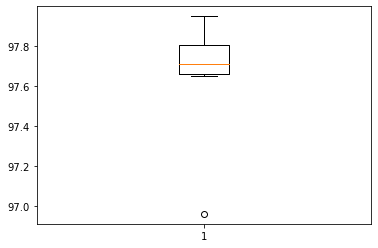

In [15]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

### Model6: with dropout regularizaition + custom optimizer

In [16]:
input_size = 28 * 28
output_size = 10
optimizer = "custom"

hidden_size = 512
batch_size = 32
learning_rate = 1e-3
epochs = 10
dropout = 0.2

test_accs = []
epoch_times = []
for i in range(10):
    tf.random.set_seed(i + 6)
    x_train, y_train, x_test, y_test = load_data(dataset="mnist")

    model6 = MLP(input_size, output_size, hidden_size, optimizer=optimizer)
    train_losses, eval_losses, train_accuracy, test_accuracy, _epoch_times = train(model6, x_train, y_train, x_test, y_test,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = dropout)
    
    acc = test(model6, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=599.5071411132812, Evaluation Loss:=0.13573551177978516, Train Acc:=96.62333333333333, Evaluation Acc:=95.87
Epoch=1 - Train Loss:=230.21409606933594, Evaluation Loss:=0.09909538179636002, Train Acc:=97.99333333333334, Evaluation Acc:=97.02
Epoch=2 - Train Loss:=166.8896026611328, Evaluation Loss:=0.10082519799470901, Train Acc:=98.23333333333333, Evaluation Acc:=97.06
Epoch=3 - Train Loss:=135.11553955078125, Evaluation Loss:=0.08147529512643814, Train Acc:=98.655, Evaluation Acc:=97.59
Epoch=4 - Train Loss:=109.17586517333984, Evaluation Loss:=0.09814437478780746, Train Acc:=98.70666666666666, Evaluation Acc:=97.32
Epoch=5 - Train Loss:=99.18446350097656, Evaluation Loss:=0.08902967721223831, Train Acc:=98.94166666666668, Evaluation Acc:=97.44
Epoch=6 - Train Loss:=82.13459777832031, Evaluation Loss:=0.0742400735616684, Train Acc:=99.33333333333333, Evaluation Acc:=98.03
Epoch=7 - Train Loss:=76.38065338134766, Evaluation Loss:=0.09132698178291321, Train Acc:=99

the mean of 10 runs is 97.748, and the variance is 0.045275999999999234
the average running time for one epoch is: 40.69951018810272


{'boxes': [<matplotlib.lines.Line2D at 0x7fec3c553ed0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fec3c4ff610>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fec3c46aa50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fec3c46a510>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fec3c7597d0>,
  <matplotlib.lines.Line2D at 0x7fec3c4ff390>]}

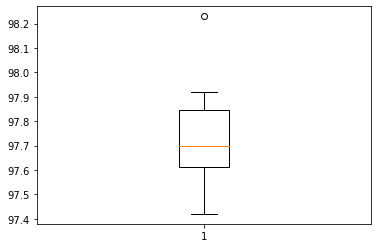

In [17]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

## FASHION MNIST Dataset

visualize sample data

4431872/4422102 [==============================] - 0s 0us/step
sample image shape: (28, 28)
sample image label: 9


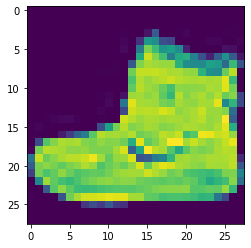

In [6]:
train_x, train_y, test_x, test_y = load_data(dataset="fashion_mnist")
sample = tf.reshape(train_x[0], (28,28))
print(f"sample image shape: {sample.shape}")
print(f"sample image label: {train_y[0]}")
plt.imshow(sample)

### Model7: without regularization + SGD optimizer

In [19]:
image_size = 28
input_size = image_size * image_size
output_size = 10

optimizer = "SGD"
hidden_size = 1024
batch_size = 32
learning_rate = 10e-5
epochs = 20

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i + 7)
    x_train, y_train, x_test, y_test = load_data(dataset="fashion_mnist")

    model7 = MLP(input_size, output_size, hidden_size = hidden_size, optimizer = optimizer)
    train_losses, test_losses, train_accuracy, test_accuracy, _epoch_times = train(model7, x_train, y_train, x_test, y_test,
                                                                 batch_size=batch_size,
                                                                 learning_rate=learning_rate,
                                                                 epochs=epochs)
    acc = test(model7, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=3783.4521484375, Evaluation Loss:=1.342052698135376, Train Acc:=74.22833333333332, Evaluation Acc:=72.78
Epoch=1 - Train Loss:=2100.505126953125, Evaluation Loss:=1.095248818397522, Train Acc:=77.39166666666667, Evaluation Acc:=75.71
Epoch=2 - Train Loss:=1780.143310546875, Evaluation Loss:=0.9963443279266357, Train Acc:=78.7, Evaluation Acc:=77.13
Epoch=3 - Train Loss:=1598.6038818359375, Evaluation Loss:=0.9535218477249146, Train Acc:=78.46, Evaluation Acc:=76.82
Epoch=4 - Train Loss:=1467.3974609375, Evaluation Loss:=0.8602468967437744, Train Acc:=80.7, Evaluation Acc:=78.97
Epoch=5 - Train Loss:=1373.647216796875, Evaluation Loss:=0.8127198815345764, Train Acc:=81.44, Evaluation Acc:=79.47
Epoch=6 - Train Loss:=1295.8265380859375, Evaluation Loss:=0.7745304107666016, Train Acc:=82.11500000000001, Evaluation Acc:=80.25
Epoch=7 - Train Loss:=1236.91015625, Evaluation Loss:=0.7525080442428589, Train Acc:=82.625, Evaluation Acc:=80.47999999999999
Epoch=8 - Train L

the mean of 10 runs is 82.71300000000001, and the variance is 0.10582099999999946
the average running time for one epoch is: 16.031194831132886


{'boxes': [<matplotlib.lines.Line2D at 0x7fec3c2ed690>],
 'caps': [<matplotlib.lines.Line2D at 0x7fec3c2f4750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fec3c27d790>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fec3c27d250>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fec3c2edc90>,
  <matplotlib.lines.Line2D at 0x7fec3c2f4210>]}

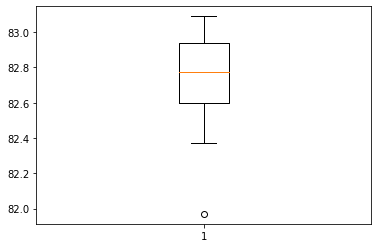

In [20]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

### Model8: with dropout and L2 regularization + SGD optimizer

In [7]:
image_size = 28
input_size = image_size * image_size
output_size = 10

optimizer = "SGD"
hidden_size = 1024
batch_size = 32
learning_rate = 10e-5
dropout = 0.1
beta = 0.001
epochs = 20

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i+8)
    x_train, y_train, x_test, y_test = load_data(dataset="fashion_mnist")

    model8 = MLP(input_size, output_size, hidden_size = hidden_size, optimizer = optimizer)
    train_losses, test_losses, train_accuracy, test_accuracy, _epoch_times = train(model8, x_train, y_train, x_test, y_test,
                                                                 batch_size=batch_size,
                                                                 learning_rate=learning_rate,
                                                                 epochs=epochs,
                                                                 dropout_rate=dropout,
                                                                 beta=beta)
    acc = test(model8, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=33756.90625, Evaluation Loss:=1.4648934602737427, Train Acc:=75.15833333333333, Evaluation Acc:=74.09
Epoch=1 - Train Loss:=30323.48046875, Evaluation Loss:=1.2087197303771973, Train Acc:=77.71166666666667, Evaluation Acc:=76.22
Epoch=2 - Train Loss:=29770.123046875, Evaluation Loss:=1.0429911613464355, Train Acc:=79.53333333333333, Evaluation Acc:=78.21000000000001
Epoch=3 - Train Loss:=29490.4296875, Evaluation Loss:=0.9679412245750427, Train Acc:=80.54833333333333, Evaluation Acc:=79.10000000000001
Epoch=4 - Train Loss:=29272.873046875, Evaluation Loss:=0.9241588115692139, Train Acc:=80.945, Evaluation Acc:=79.23
Epoch=5 - Train Loss:=29141.552734375, Evaluation Loss:=0.8637877106666565, Train Acc:=81.53333333333333, Evaluation Acc:=79.95
Epoch=6 - Train Loss:=29005.37890625, Evaluation Loss:=0.8473775386810303, Train Acc:=81.66166666666666, Evaluation Acc:=80.01
Epoch=7 - Train Loss:=28898.71484375, Evaluation Loss:=0.7982996702194214, Train Acc:=82.4183333333

the mean of 10 runs is 81.608, and the variance is 1.7098160000000076
the average running time for one epoch is: 24.38683134198189


{'boxes': [<matplotlib.lines.Line2D at 0x7f8dee341050>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8dee34d110>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8dee353150>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8dee34dbd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8dee341650>,
  <matplotlib.lines.Line2D at 0x7f8dee341b90>]}

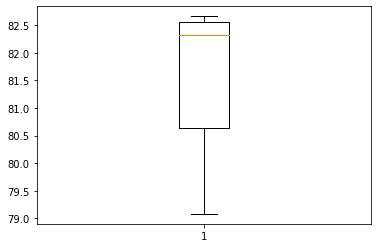

In [8]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

### Model9: without regularization + Adam optimizer

In [9]:
image_size = 28
input_size = image_size * image_size
output_size = 10

optimizer = "Adam"
hidden_size = 1024
batch_size = 32
learning_rate = 10e-5
epochs = 20

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i + 9)
    x_train, y_train, x_test, y_test = load_data(dataset="fashion_mnist")

    model9 = MLP(input_size, output_size, hidden_size = hidden_size, optimizer = optimizer)
    train_losses, test_losses, train_accuracy, test_accuracy, _epoch_times = train(model9, x_train, y_train, x_test, y_test,
                                                                 batch_size=batch_size,
                                                                 learning_rate=learning_rate,
                                                                 epochs=epochs)
    acc = test(model9, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=2727.406005859375, Evaluation Loss:=1.2817211151123047, Train Acc:=81.54166666666667, Evaluation Acc:=80.13
Epoch=1 - Train Loss:=1791.2176513671875, Evaluation Loss:=1.3142421245574951, Train Acc:=79.30666666666667, Evaluation Acc:=76.9
Epoch=2 - Train Loss:=1664.578857421875, Evaluation Loss:=0.9824911952018738, Train Acc:=84.92, Evaluation Acc:=82.46
Epoch=3 - Train Loss:=1625.421875, Evaluation Loss:=0.9002737402915955, Train Acc:=86.53833333333333, Evaluation Acc:=84.34
Epoch=4 - Train Loss:=1649.998291015625, Evaluation Loss:=0.9558119177818298, Train Acc:=86.45333333333333, Evaluation Acc:=83.72
Epoch=5 - Train Loss:=1677.6854248046875, Evaluation Loss:=1.1325474977493286, Train Acc:=85.04833333333333, Evaluation Acc:=82.64
Epoch=6 - Train Loss:=1750.032958984375, Evaluation Loss:=1.165761947631836, Train Acc:=86.45666666666668, Evaluation Acc:=84.46000000000001
Epoch=7 - Train Loss:=1762.091796875, Evaluation Loss:=1.3647196292877197, Train Acc:=85.0249999

the mean of 10 runs is 84.396, and the variance is 3.328423999999999
the average running time for one epoch is: 40.13925552606583


{'boxes': [<matplotlib.lines.Line2D at 0x7f8dee174ad0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8dee0fab50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8dee102b90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8dee102650>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8dee0fa0d0>,
  <matplotlib.lines.Line2D at 0x7f8dee0fa610>]}

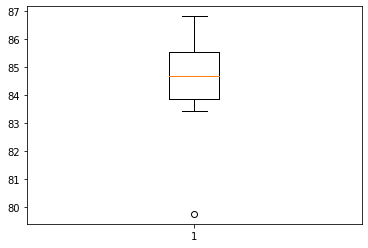

In [10]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

### Model10: with dropout and L2 regularization + Adam optimizer

In [13]:
image_size = 28
input_size = image_size * image_size
output_size = 10

optimizer = "Adam"
hidden_size = 1024
batch_size = 32
learning_rate = 10e-5
dropout = 0.1
beta = 0.001
epochs = 20

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i+10)
    x_train, y_train, x_test, y_test = load_data(dataset="fashion_mnist")

    model10 = MLP(input_size, output_size, hidden_size = hidden_size, optimizer = optimizer)
    train_losses, test_losses, train_accuracy, test_accuracy, _epoch_times = train(model10, x_train, y_train, x_test, y_test,
                                                                 batch_size=batch_size,
                                                                 learning_rate=learning_rate,
                                                                 epochs=epochs,
                                                                 dropout_rate=dropout,
                                                                 beta=beta)
    acc = test(model10, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=19619.216796875, Evaluation Loss:=0.7594018578529358, Train Acc:=83.395, Evaluation Acc:=82.06
Epoch=1 - Train Loss:=9751.0859375, Evaluation Loss:=0.6168406009674072, Train Acc:=83.53333333333333, Evaluation Acc:=82.41000000000001
Epoch=2 - Train Loss:=6965.02783203125, Evaluation Loss:=0.6041348576545715, Train Acc:=84.51166666666666, Evaluation Acc:=82.95
Epoch=3 - Train Loss:=5437.71826171875, Evaluation Loss:=0.4992223083972931, Train Acc:=86.05333333333334, Evaluation Acc:=84.61999999999999
Epoch=4 - Train Loss:=4443.2470703125, Evaluation Loss:=0.5003650188446045, Train Acc:=85.92166666666667, Evaluation Acc:=84.13000000000001
Epoch=5 - Train Loss:=3788.18505859375, Evaluation Loss:=0.5043657422065735, Train Acc:=85.75166666666667, Evaluation Acc:=84.26
Epoch=6 - Train Loss:=3288.885009765625, Evaluation Loss:=0.6061462163925171, Train Acc:=83.76666666666667, Evaluation Acc:=82.24000000000001
Epoch=7 - Train Loss:=2923.3623046875, Evaluation Loss:=0.5052078

the mean of 10 runs is 83.451, and the variance is 1.149649000000003
the average running time for one epoch is: 48.47898581147194


{'boxes': [<matplotlib.lines.Line2D at 0x7f8dee3271d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8dab81a250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8dab821290>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8dab81ad10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8dee327790>,
  <matplotlib.lines.Line2D at 0x7f8dee327cd0>]}

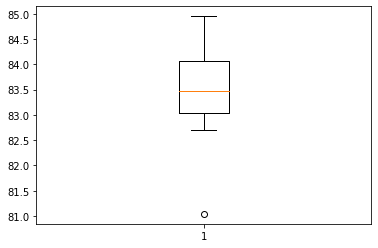

In [14]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

### Model11: without regularization + custom optimizer

In [15]:
image_size = 28
input_size = image_size * image_size
output_size = 10

optimizer = "custom"
hidden_size = 1024
batch_size = 32
learning_rate = 10e-5
epochs = 20

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i + 11)
    x_train, y_train, x_test, y_test = load_data(dataset="fashion_mnist")

    model11 = MLP(input_size, output_size, hidden_size = hidden_size, optimizer = optimizer)
    train_losses, test_losses, train_accuracy, test_accuracy, _epoch_times = train(model11, x_train, y_train, x_test, y_test,
                                                                 batch_size=batch_size,
                                                                 learning_rate=learning_rate,
                                                                 epochs=epochs)
    acc = test(model11, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=1884.739013671875, Evaluation Loss:=0.7140969634056091, Train Acc:=83.50166666666667, Evaluation Acc:=81.36
Epoch=1 - Train Loss:=955.9222412109375, Evaluation Loss:=0.5643201470375061, Train Acc:=86.16166666666668, Evaluation Acc:=82.92
Epoch=2 - Train Loss:=723.19580078125, Evaluation Loss:=0.48924532532691956, Train Acc:=88.43833333333333, Evaluation Acc:=84.98
Epoch=3 - Train Loss:=618.942138671875, Evaluation Loss:=0.4266833961009979, Train Acc:=90.34666666666666, Evaluation Acc:=86.09
Epoch=4 - Train Loss:=521.4966430664062, Evaluation Loss:=0.42026397585868835, Train Acc:=91.50500000000001, Evaluation Acc:=86.11
Epoch=5 - Train Loss:=462.04229736328125, Evaluation Loss:=0.41882768273353577, Train Acc:=92.245, Evaluation Acc:=87.11
Epoch=6 - Train Loss:=411.19110107421875, Evaluation Loss:=0.44027969241142273, Train Acc:=91.53999999999999, Evaluation Acc:=86.1
Epoch=7 - Train Loss:=361.8301086425781, Evaluation Loss:=0.38612306118011475, Train Acc:=94.401666

the mean of 10 runs is 88.478, and the variance is 0.04247600000000018
the average running time for one epoch is: 48.32909945487976


{'boxes': [<matplotlib.lines.Line2D at 0x7f8dab4801d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8dab487250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8dab487fd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8dab487ad0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8dab480790>,
  <matplotlib.lines.Line2D at 0x7f8dab480cd0>]}

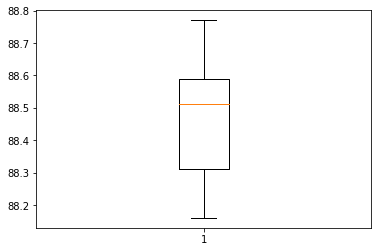

In [16]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)

### Model12: with dropout and L2 regularization + custom optimizer

In [17]:
image_size = 28
input_size = image_size * image_size
output_size = 10

optimizer = "custom"
hidden_size = 1024
batch_size = 32
learning_rate = 10e-5
dropout = 0.1
beta = 0.001
epochs = 20

test_accs = []
epoch_times = []

for i in range(10):
    tf.random.set_seed(i+21)
    x_train, y_train, x_test, y_test = load_data(dataset="fashion_mnist")

    model12 = MLP(input_size, output_size, hidden_size = hidden_size, optimizer = optimizer)
    train_losses, test_losses, train_accuracy, test_accuracy, _epoch_times = train(model12, x_train, y_train, x_test, y_test,
                                                                 batch_size=batch_size,
                                                                 learning_rate=learning_rate,
                                                                 epochs=epochs,
                                                                 dropout_rate=dropout,
                                                                 beta=beta)
    acc = test(model12, x_test, y_test)
    test_accs.append(acc)
    epoch_times.append(np.mean(_epoch_times))

Epoch=0 - Train Loss:=25847.658203125, Evaluation Loss:=0.701223611831665, Train Acc:=84.32666666666667, Evaluation Acc:=82.08
Epoch=1 - Train Loss:=20097.58984375, Evaluation Loss:=0.5288601517677307, Train Acc:=86.07666666666667, Evaluation Acc:=83.46000000000001
Epoch=2 - Train Loss:=17040.9296875, Evaluation Loss:=0.42841699719429016, Train Acc:=88.63333333333333, Evaluation Acc:=85.63
Epoch=3 - Train Loss:=14296.21484375, Evaluation Loss:=0.426090806722641, Train Acc:=88.03333333333333, Evaluation Acc:=85.0
Epoch=4 - Train Loss:=11882.58984375, Evaluation Loss:=0.3875444829463959, Train Acc:=89.51666666666667, Evaluation Acc:=86.44
Epoch=5 - Train Loss:=9881.3955078125, Evaluation Loss:=0.39705365896224976, Train Acc:=89.46499999999999, Evaluation Acc:=85.65
Epoch=6 - Train Loss:=8272.27734375, Evaluation Loss:=0.3630055785179138, Train Acc:=91.12, Evaluation Acc:=87.28
Epoch=7 - Train Loss:=6995.63525390625, Evaluation Loss:=0.3434748649597168, Train Acc:=91.81833333333333, Evalu

the mean of 10 runs is 88.299, and the variance is 0.05342900000000218
the average running time for one epoch is: 51.47434956431389


{'boxes': [<matplotlib.lines.Line2D at 0x7f8dab214350>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8dab2193d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8dab220410>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8dab219e90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8dab214910>,
  <matplotlib.lines.Line2D at 0x7f8dab214e50>]}

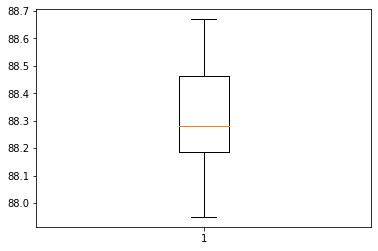

In [18]:
mean = np.mean(test_accs)
var = np.var(test_accs)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

avg_epoch_time = np.mean(epoch_times)
print(f"the average running time for one epoch is: {avg_epoch_time}")

plt.boxplot(test_accs)